# Resume Classification Training Notebook

This notebook trains multiple models, compares them, plots confusion matrices + ROC curves, and saves the best model along with TF-IDF and LabelEncoder as pickle files.

## ✅ Requirements

- Place `Cleaned_Resumes.csv` in the same folder as this notebook.
- The CSV must contain columns: `Resume_Details`, `Category`.

In [1]:
# ==============================
# ✅ FULL DEBUGGED + UPDATED CODE
# - No syntax errors (markdown text fixed)
# - Consistent LabelEncoder usage
# - Tree/boosting models handle sparse TF-IDF (small dataset -> safe to densify)
# - ROC uses proper scores/probabilities (not hard predictions)
# - Generates pickle files: best_model.pkl, tfidf_vectorizer.pkl, label_encoder.pkl, model_metadata.pkl
# ==============================

import os
import pickle
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Optional: seaborn (won't crash if not installed)
try:
    import seaborn as sns
    sns.set_style("darkgrid")
except Exception:
    sns = None

import matplotlib.pyplot as plt

# Works in notebook; won't crash in .py
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)

# Optional: XGBoost (not used below, but kept to match your imports without breaking)
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

In [2]:
# ==============================
# 1) Load Dataset
# ==============================
resume_data = pd.read_csv("Cleaned_Resumes.csv")
print("Dataset shape:", resume_data.shape)
print("Columns:", resume_data.columns.tolist())
print(resume_data.head())

print("\nNulls per column:\n", resume_data.isnull().sum())

Dataset shape: (52, 2)
Columns: ['Category', 'Resume_Details']
     Category                                     Resume_Details
0  PeopleSoft  anubhav kumar singh core competencies scriptin...
1  PeopleSoft  classification internal classification interna...
2  PeopleSoft  sirazuddin bangalore india sirazuddin bangalor...
3  PeopleSoft  peoplesoft admin varkala vikas career objectiv...
4  PeopleSoft  peoplesoft administration vivekanand sayana ca...

Nulls per column:
 Category          0
Resume_Details    0
dtype: int64


In [3]:
# ==============================
# 2) Label Encoding (consistent usage)
# ==============================
label_encoder = LabelEncoder()
resume_data["LebelEncoding"] = label_encoder.fit_transform(resume_data["Category"])  # keeping your column name
print("\nEncoded sample:\n", resume_data[["Category", "LebelEncoding"]].head())
print("\nClasses:", list(label_encoder.classes_))

# ==============================
# 3) Train-Test Split
# ==============================
X = resume_data["Resume_Details"].astype(str).values
y = resume_data["Category"].astype(str).values
y_encoded = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("\nTrain size:", len(X_train), "Test size:", len(X_test))


Encoded sample:
      Category  LebelEncoding
0  PeopleSoft              0
1  PeopleSoft              0
2  PeopleSoft              0
3  PeopleSoft              0
4  PeopleSoft              0

Classes: ['PeopleSoft', 'React Developer', 'SQL Developer', 'Workday']

Train size: 41 Test size: 11


In [4]:
# ==============================
# 4) TF-IDF Vectorization
# ==============================
# Converts resume text into numerical vectors using TF-IDF (best for text classification)
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("\nTF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# Helper: some models need dense arrays (tree/boosting models)
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# ==============================
# Helper Functions (CM + ROC)
# ==============================
def plot_conf_mat(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(xticks_rotation=45)
    plt.title(title)
    plt.show()

def get_multiclass_scores(model, X_sparse, X_dense, needs_dense=False):
    # Returns score matrix (n_samples, n_classes) for ROC.
    # Prefer predict_proba; else decision_function; else fallback to one-hot predictions.
    X_use = X_dense if needs_dense else X_sparse

    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_use)
        return scores

    if hasattr(model, "decision_function"):
        scores = model.decision_function(X_use)
        # If binary, convert to 2 columns
        if scores.ndim == 1:
            scores = np.column_stack([-scores, scores])
        return scores

    # Fallback (not ideal): one-hot from predictions
    pred = model.predict(X_use)
    n_classes = len(label_encoder.classes_)
    scores = label_binarize(pred, classes=list(range(n_classes)))
    return scores

def plot_multiclass_roc(y_true, scores, title="ROC Curve - Multi-class"):
    n_classes = len(label_encoder.classes_)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    plt.figure(figsize=(9, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(name, model, X_tr_sp, X_te_sp, X_tr_dn, X_te_dn, needs_dense=False):
    Xtr = X_tr_dn if needs_dense else X_tr_sp
    Xte = X_te_dn if needs_dense else X_te_sp

    model.fit(Xtr, y_train)
    preds = model.predict(Xte)

    acc = accuracy_score(y_test, preds)
    print("\n" + "="*60)
    print(f"### {name}")
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, preds, target_names=label_encoder.classes_))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, preds))

    plot_conf_mat(y_test, preds, title=f"{name} - Confusion Matrix")

    scores = get_multiclass_scores(model, X_te_sp, X_te_dn, needs_dense=needs_dense)
    plot_multiclass_roc(y_test, scores, title=f"{name} - ROC Curve (Multi-class)")

    return acc, model



TF-IDF Train shape: (41, 2712)
TF-IDF Test shape: (11, 2712)



### SVM (LinearSVC)
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         4
  SQL Developer       1.00      1.00      1.00         3
        Workday       1.00      1.00      1.00         2

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]


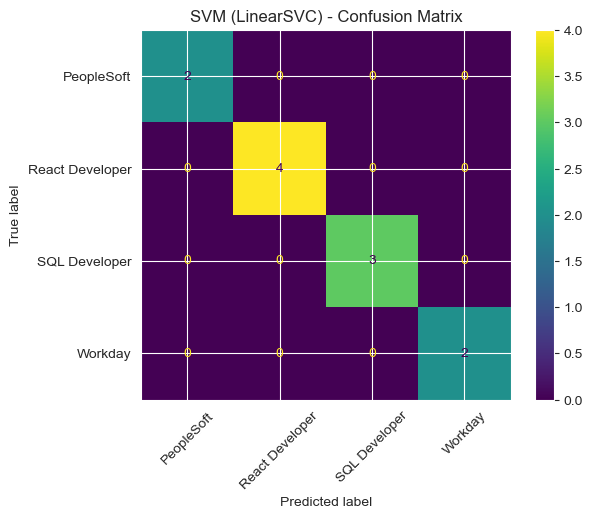

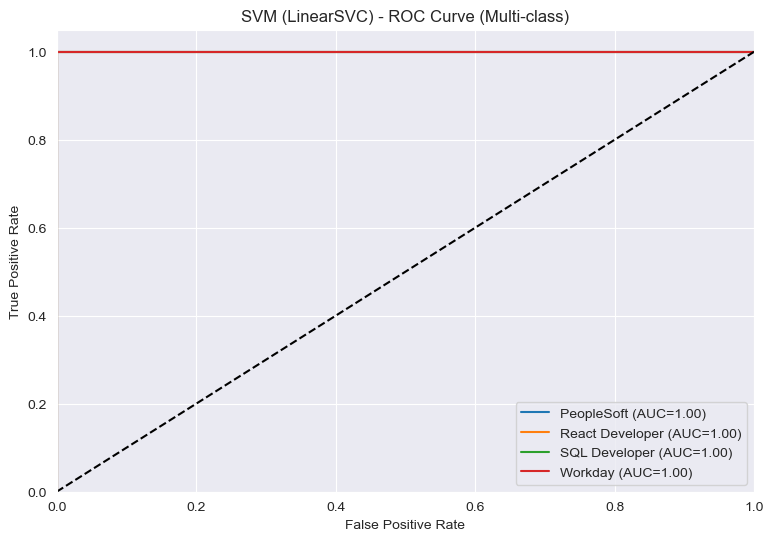

In [5]:
# ==============================
# 5) Model Building (7 models)
# ==============================

# 1. SVM (LinearSVC)
svm_model = LinearSVC()
svm_acc, svm_model = evaluate_model(
    "SVM (LinearSVC)", svm_model,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=False
)


### Logistic Regression
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         4
  SQL Developer       1.00      1.00      1.00         3
        Workday       1.00      1.00      1.00         2

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]


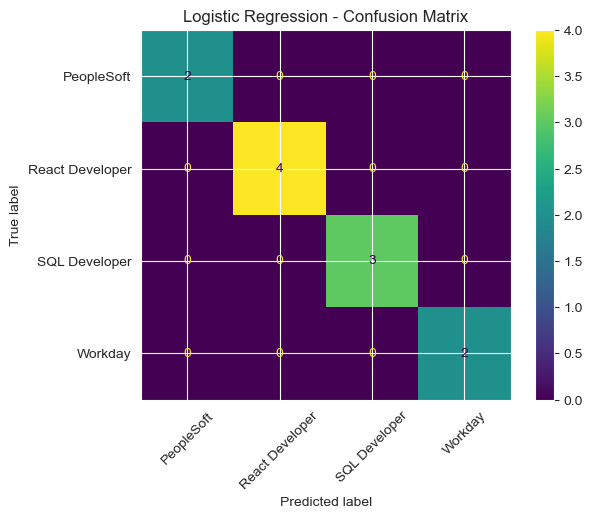

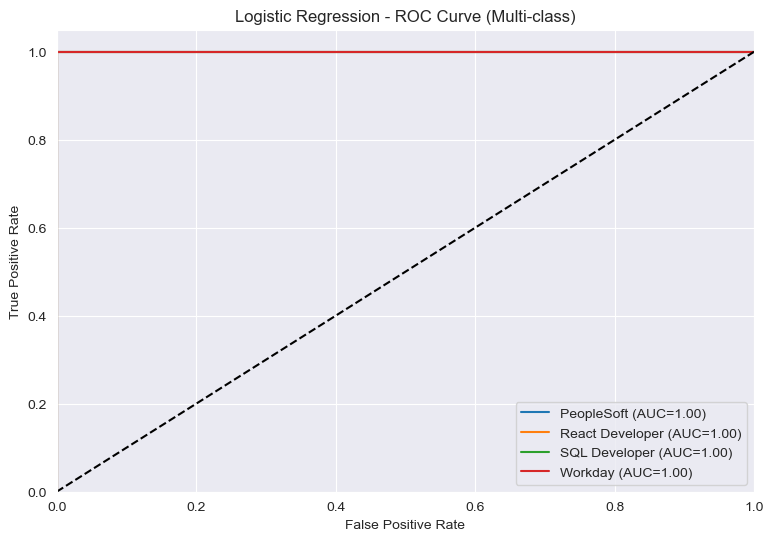

In [6]:
# 2. Logistic Regression
log_reg = LogisticRegression(max_iter=300)
lr_acc, log_reg = evaluate_model(
    "Logistic Regression", log_reg,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=False
)


### Multinomial Naive Bayes
Accuracy: 0.8181818181818182

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      0.50      0.67         2
React Developer       0.67      1.00      0.80         4
  SQL Developer       1.00      0.67      0.80         3
        Workday       1.00      1.00      1.00         2

       accuracy                           0.82        11
      macro avg       0.92      0.79      0.82        11
   weighted avg       0.88      0.82      0.81        11


Confusion Matrix:
 [[1 1 0 0]
 [0 4 0 0]
 [0 1 2 0]
 [0 0 0 2]]


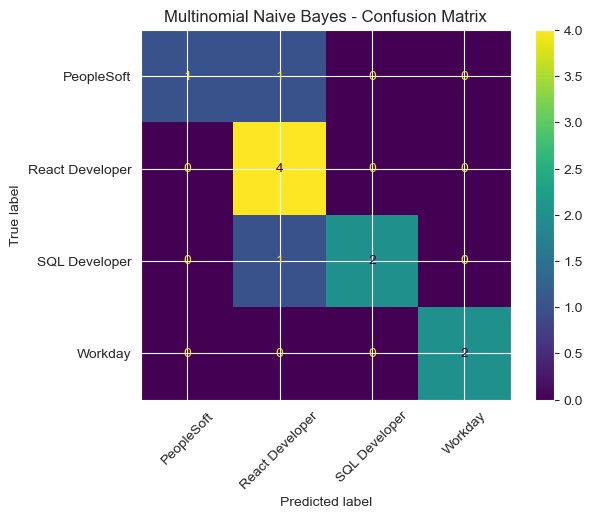

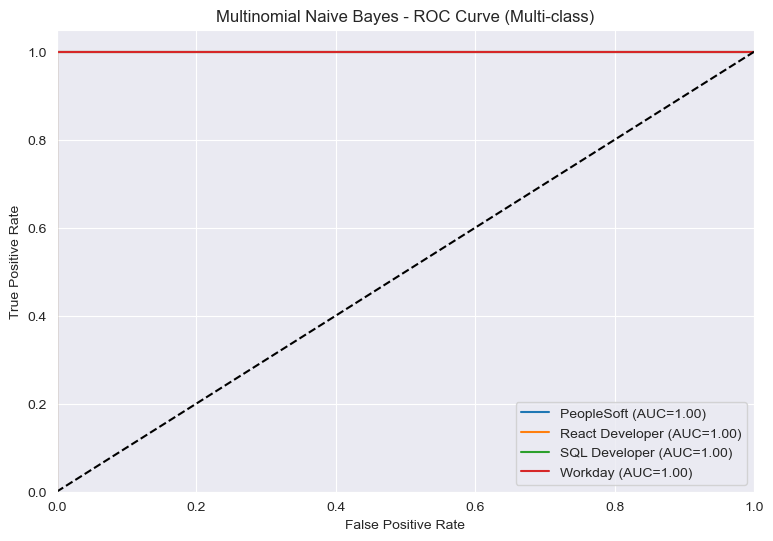

In [7]:
# 3. Multinomial Naive Bayes
nb = MultinomialNB()
nb_acc, nb = evaluate_model(
    "Multinomial Naive Bayes", nb,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=False
)


### Random Forest
Accuracy: 0.9090909090909091

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      1.00      1.00         2
React Developer       0.80      1.00      0.89         4
  SQL Developer       1.00      0.67      0.80         3
        Workday       1.00      1.00      1.00         2

       accuracy                           0.91        11
      macro avg       0.95      0.92      0.92        11
   weighted avg       0.93      0.91      0.91        11


Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 1 2 0]
 [0 0 0 2]]


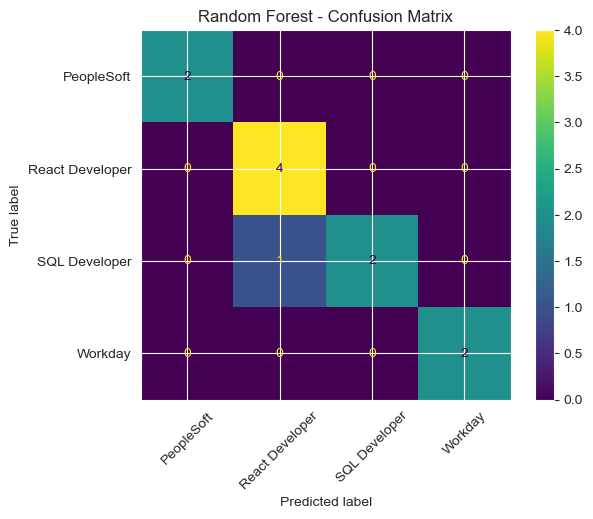

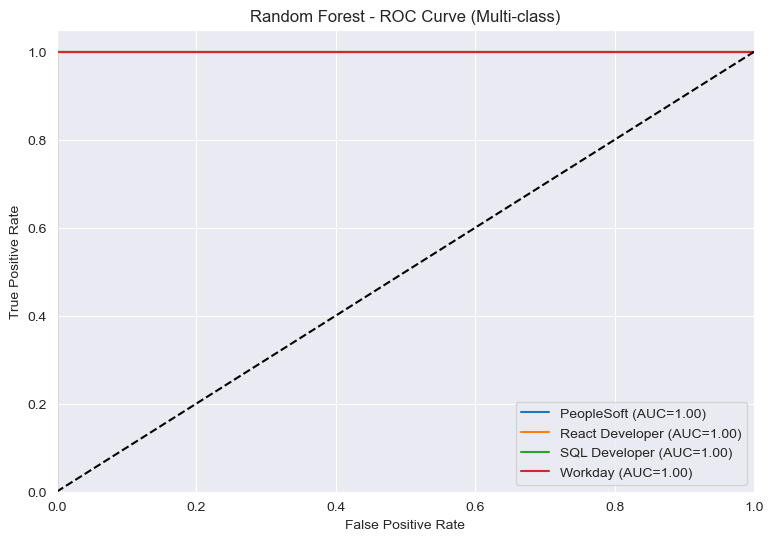

In [8]:
# 4. Random Forest (needs dense)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_acc, rf = evaluate_model(
    "Random Forest", rf,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=True
)


Best KNN Parameters: {'metric': 'cosine', 'n_neighbors': 1, 'weights': 'uniform'}
Best KNN CV Accuracy: 1.0

### KNN (Best from GridSearch)
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         4
  SQL Developer       1.00      1.00      1.00         3
        Workday       1.00      1.00      1.00         2

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]


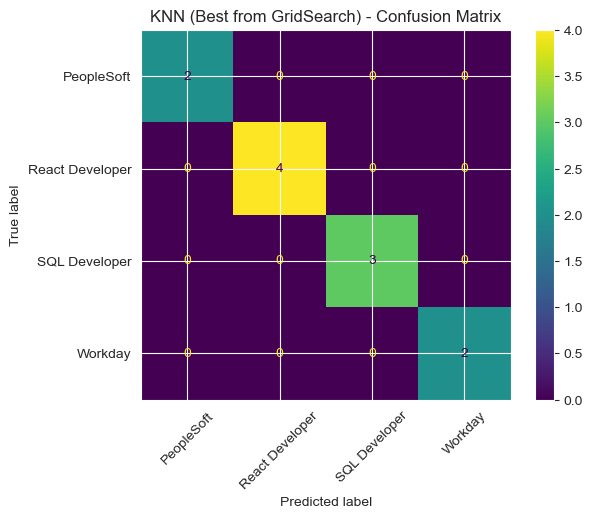

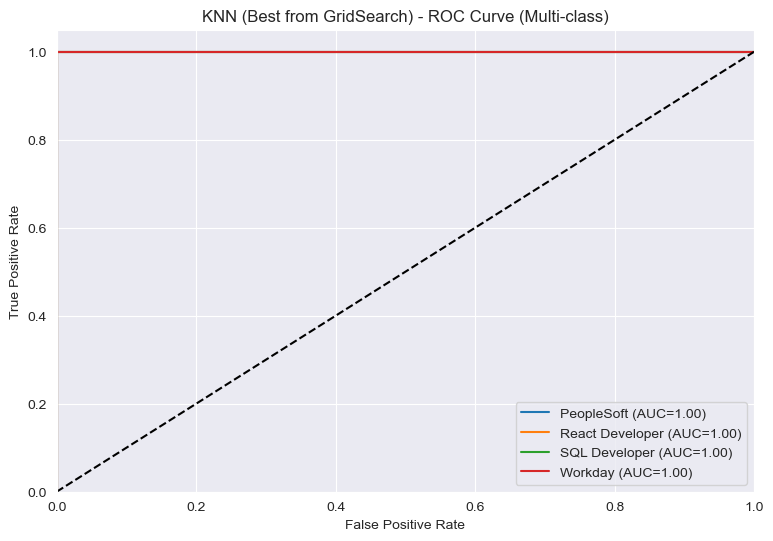

In [9]:
# 5. KNN + GridSearchCV (works with sparse + cosine)
# Tuning:
# - n_neighbors
# - metric: cosine/euclidean/manhattan
# - weights: uniform/distance
param_grid = {
    "n_neighbors": [1, 3, 5, 7, 9, 11],
    "metric": ["cosine", "euclidean", "manhattan"],
    "weights": ["uniform", "distance"]
}

knn_base = KNeighborsClassifier()
grid = GridSearchCV(
    knn_base,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X_train_tfidf, y_train)

print("\nBest KNN Parameters:", grid.best_params_)
print("Best KNN CV Accuracy:", grid.best_score_)

knn = grid.best_estimator_
knn_acc, knn = evaluate_model(
    "KNN (Best from GridSearch)", knn,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=False
)


### AdaBoost
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         4
  SQL Developer       1.00      1.00      1.00         3
        Workday       1.00      1.00      1.00         2

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]


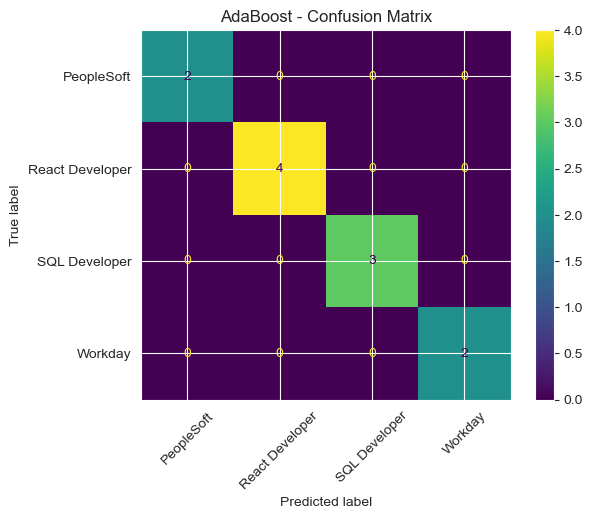

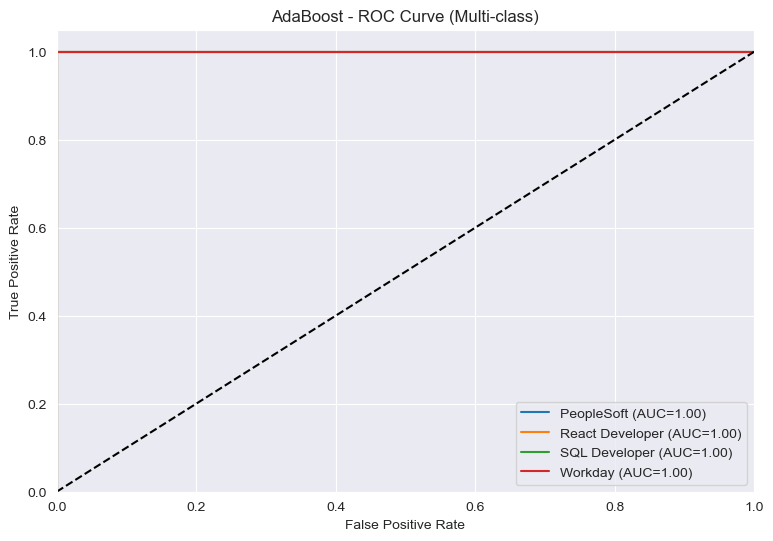

In [10]:
# 6. AdaBoost (needs dense)
base_tree = DecisionTreeClassifier(max_depth=1, random_state=42)
adaboost = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
ada_acc, adaboost = evaluate_model(
    "AdaBoost", adaboost,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=True
)


### Gradient Boosting
Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

     PeopleSoft       1.00      1.00      1.00         2
React Developer       1.00      1.00      1.00         4
  SQL Developer       1.00      1.00      1.00         3
        Workday       1.00      1.00      1.00         2

       accuracy                           1.00        11
      macro avg       1.00      1.00      1.00        11
   weighted avg       1.00      1.00      1.00        11


Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]


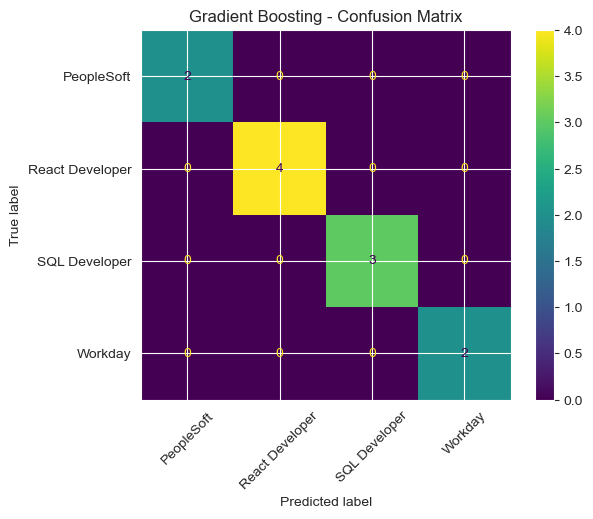

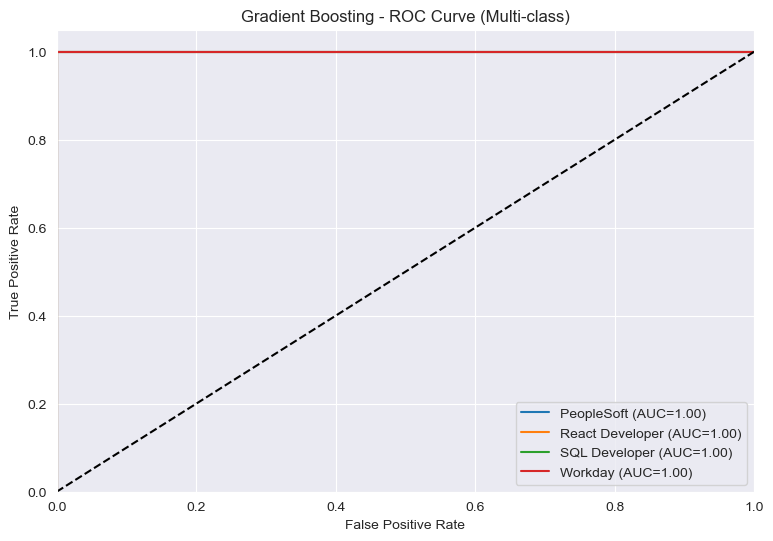

In [11]:
# 7. Gradient Boosting (needs dense)
gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbc_acc, gbc = evaluate_model(
    "Gradient Boosting", gbc,
    X_train_tfidf, X_test_tfidf, X_train_dense, X_test_dense,
    needs_dense=True
)

In [12]:
# ==============================
# 6) Model Comparison (Test + CV)
# ==============================
models = {
    "SVM (LinearSVC)": (svm_model, False),
    "Logistic Regression": (log_reg, False),
    "Multinomial Naive Bayes": (nb, False),
    "Random Forest": (rf, True),
    "KNN (Best from GridSearch)": (knn, False),
    "AdaBoost": (adaboost, True),
    "Gradient Boosting": (gbc, True)
}

comparison_results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, (clf, needs_dense) in models.items():
    Xtr = X_train_dense if needs_dense else X_train_tfidf
    Xte = X_test_dense if needs_dense else X_test_tfidf

    test_acc = accuracy_score(y_test, clf.predict(Xte))
    cv_scores = cross_val_score(clf, Xtr, y_train, cv=cv, scoring="accuracy")

    comparison_results.append({
        "Model": name,
        "Test Accuracy": test_acc,
        "CV Mean Accuracy": cv_scores.mean(),
        "CV Std Dev": cv_scores.std()
    })

comparison_df = pd.DataFrame(comparison_results).sort_values(
    by=["CV Mean Accuracy", "Test Accuracy"],
    ascending=False
)

print("\n==================== MODEL COMPARISON ====================\n")
print(comparison_df)


==================== MODEL COMPARISON ====================

                        Model  Test Accuracy  CV Mean Accuracy  CV Std Dev
6           Gradient Boosting       1.000000          1.000000    0.000000
4  KNN (Best from GridSearch)       1.000000          0.977778    0.044444
0             SVM (LinearSVC)       1.000000          0.952778    0.058002
1         Logistic Regression       1.000000          0.930556    0.090438
3               Random Forest       0.909091          0.930556    0.090438
2     Multinomial Naive Bayes       0.818182          0.883333    0.145297
5                    AdaBoost       1.000000          0.483333    0.155009


In [13]:
# ==============================
# 7) Select Best Model + Save Pickles
# ==============================
best_row = comparison_df.iloc[0]
best_model_name = best_row["Model"]
best_model, best_needs_dense = models[best_model_name]

print("\n🏆 Best Model Selected:", best_model_name)
print("Best Model Test Accuracy:", best_row["Test Accuracy"])
print("Best Model CV Mean Accuracy:", best_row["CV Mean Accuracy"])

MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

best_model_path = os.path.join(MODELS_DIR, "best_model.pkl")
tfidf_path = os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl")
le_path = os.path.join(MODELS_DIR, "label_encoder.pkl")
meta_path = os.path.join(MODELS_DIR, "model_metadata.pkl")

with open(best_model_path, "wb") as f:
    pickle.dump(best_model, f)

with open(tfidf_path, "wb") as f:
    pickle.dump(tfidf, f)

with open(le_path, "wb") as f:
    pickle.dump(label_encoder, f)

metadata = {
    "best_model_name": best_model_name,
    "needs_dense": bool(best_needs_dense),
    "tfidf_max_features": 5000,
    "tfidf_stop_words": "english",
    "n_classes": len(label_encoder.classes_),
    "classes": list(label_encoder.classes_),
    "train_size": int(len(X_train)),
    "test_size": int(len(X_test)),
    "random_state": 42
}

with open(meta_path, "wb") as f:
    pickle.dump(metadata, f)

print("\n✅ Pickle files generated successfully in:", os.path.abspath(MODELS_DIR))
print(" -", best_model_path)
print(" -", tfidf_path)
print(" -", le_path)
print(" -", meta_path)


🏆 Best Model Selected: Gradient Boosting
Best Model Test Accuracy: 1.0
Best Model CV Mean Accuracy: 1.0

✅ Pickle files generated successfully in: C:\Users\Aniket\Ds\new\models
 - models\best_model.pkl
 - models\tfidf_vectorizer.pkl
 - models\label_encoder.pkl
 - models\model_metadata.pkl


In [14]:
# ==============================
# 8) Quick Load-Test (optional)
# ==============================
with open(best_model_path, "rb") as f:
    loaded_model = pickle.load(f)
with open(tfidf_path, "rb") as f:
    loaded_tfidf = pickle.load(f)
with open(le_path, "rb") as f:
    loaded_le = pickle.load(f)
with open(meta_path, "rb") as f:
    loaded_meta = pickle.load(f)

sample_text = "Experienced SQL Developer with ETL, stored procedures, optimization, and reporting."
sample_vec = loaded_tfidf.transform([sample_text])

if loaded_meta["needs_dense"]:
    sample_vec_use = sample_vec.toarray()
else:
    sample_vec_use = sample_vec

pred_id = loaded_model.predict(sample_vec_use)[0]
pred_label = loaded_le.inverse_transform([pred_id])[0]

print("\n🔎 Sample Prediction:", pred_label)


🔎 Sample Prediction: SQL Developer
